## Sex and the City: The Next Generation More Episodes

## SATC:TNG

In [ ]:
import pandas as pd
import re

### Data Is sourced from Kaggle:

#### https://www.kaggle.com/snapcrack/every-sex-and-the-city-script/version/3

In [ ]:
satc = pd.read_csv("SATC_all_lines.csv")

In [ ]:
# Modify the dataset for what we will feed into our NLP model
cols = ['Speaker','Line']
satc = satc[cols]
#satc.loc[(tng['type'] == 'description') & (tng['who'].isna()), 'who'] = "DESCRIPTION"
#tng.drop(['type'], axis=1, inplace=True)

In [ ]:
satc['Speaker'] = satc['Speaker'].str.upper()
satc['Line'] = satc['Speaker'] + " :: " + satc['Line']
satc = satc.rename(columns={'Speaker': 'label', 'Line': 'text'})

satc = satc.dropna(axis=0)

satc['is_valid'] = False

satc.to_csv('train.csv')

### Read in our Edited Data Frame

In [2]:
from pathlib import Path
import pandas as pd
import re
import os
from fastai.text import *
import string
import numpy as np

%reload_ext autoreload
%autoreload 2
%matplotlib inline

cwd = os.getcwd()
path = Path(cwd)

### Here is the factory method for implementing our own vocab and tokenizer methods if we choose to do so

In [3]:
all_letters = list(string.printable + string.whitespace) #Letters need to be in a list not a string

vocab=Vocab.create(all_letters, max_vocab=80000, min_freq=0)
customtokenizer = Tokenizer(pre_rules= [], post_rules=[])

processors = [TokenizeProcessor(),
             NumericalizeProcessor()]

data = (TextList.from_csv(path, 'train.csv', cols=['text'])
                 .split_by_rand_pct(0.01)
                 .label_for_lm()
                 .databunch(bs=384))
data.save('data_block_lm.pkl')

In [4]:
data_lm = load_data(path, 'data_block_lm.pkl',bs=384)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

C:\Users\brent\AppData\Roaming\Python\Python37\site-packages\fastai\datasets.py:156: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


In [5]:
data_lm
data_lm.show_batch()

idx,text
0,"we want to own ? xxbos xxup carrie : : xxmaj tim was xxunk , a well - liked and respected investment banker who made about two million a year . xxbos xxup carrie : : xxmaj they met one evening , in typical xxmaj new xxmaj york fashion at a gallery opening . xxbos xxup tim : : xxmaj like it ? xxbos xxup elizabeth : : xxmaj yes"
1,"god , what was his name ? xxbos xxup group : : xxmaj drew . xxbos xxup carrie : : xxmaj drew the sex god . xxbos xxup samantha : : xxmaj right . xxbos xxup samantha : : xxmaj afterwards ? i did n't feel a thing . xxbos xxup samantha : : xxmaj it was like , "" xxmaj hey , babe , got ta go . xxbos"
2,"that i 'd done it . xxbos xxup carrie : : i 'd just had sex like a man . xxbos xxup carrie : : i left feeling powerful , xxunk and incredibly alive . xxbos xxup carrie : : i felt like i owned this city . xxbos xxup carrie : : xxmaj nothing and no one could get in my way . xxbos xxup carrie : : -"
3,"plus i own my own business . xxbos xxup carrie : : xxmaj samantha had the kind of deluded self - xxunk that caused men like xxmaj ross xxmaj xxunk to run for president and it usually got her what she wanted . xxbos xxup samantha : : xxmaj well , if you 're not gon na hit on him , i will . xxbos xxup carrie : : xxmaj"
4,"xxup guest 1 : : xxmaj bing xxmaj crosby , i stand by my choice xxbos xxup miranda : : xxmaj sean xxmaj xxunk . xxbos xxup miranda : : xxmaj yesterday , today and tomorrow . xxbos xxup carrie : : xxmaj for a first date , xxmaj miranda felt like she was hitting it out of the ballpark . xxbos xxup miranda : : xxmaj thanks . xxbos"


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


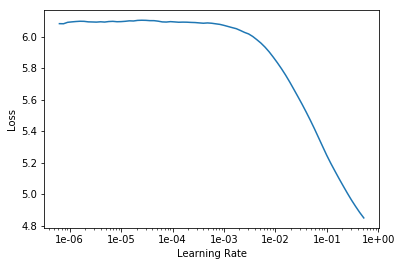

In [6]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [7]:
learn.fit_one_cycle(20, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.903359,5.458708,0.168229,00:11
1,5.378942,4.258925,0.266815,00:11
2,4.675931,3.423292,0.395461,00:11
3,4.030128,2.827710,0.471577,00:11
4,3.530687,2.728088,0.480878,00:11
5,3.198222,2.685916,0.482850,00:11
6,2.970131,2.661168,0.486272,00:11
7,2.812135,2.651084,0.489100,00:11
8,2.696773,2.649864,0.488876,00:11
9,2.613696,2.642417,0.489844,00:11


In [8]:
learn.save('fit_head')

In [9]:
learn.unfreeze()

In [10]:
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.329041,2.627448,0.493787,00:15
1,2.305839,2.623954,0.493415,00:15
2,2.286514,2.617912,0.496391,00:15
3,2.267854,2.613996,0.496726,00:15
4,2.244901,2.606811,0.497396,00:15
5,2.215837,2.618395,0.496689,00:15
6,2.194420,2.617142,0.497173,00:15
7,2.159266,2.633120,0.496168,00:15
8,2.118809,2.637964,0.495722,00:15
9,2.083519,2.652978,0.495089,00:15


In [11]:
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')

In [12]:
learn.fit_one_cycle(20, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.844090,2.707619,0.494271,00:15
1,1.850467,2.704762,0.494792,00:15
2,1.848465,2.707257,0.494345,00:15
3,1.848160,2.711402,0.495127,00:15
4,1.847846,2.710399,0.493936,00:15
5,1.848554,2.712913,0.493936,00:15
6,1.844034,2.714288,0.494643,00:15
7,1.837803,2.712879,0.493527,00:15
8,1.849705,2.708090,0.494568,00:15
9,1.846744,2.721080,0.494457,00:15


In [13]:
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')

# We have our trained model Now

In [14]:
from pathlib import Path
import pandas as pd
import re
import os
from fastai.text import *
import string
import numpy as np

%reload_ext autoreload
%autoreload 2
%matplotlib inline

cwd = os.getcwd()
path = Path(cwd)

In [15]:
data_lm = load_data(path, 'data_block_lm.pkl',bs=384)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.load('fine_tuned')
learn.load_encoder('fine_tuned_enc')

C:\Users\brent\AppData\Roaming\Python\Python37\site-packages\fastai\datasets.py:156: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


In [17]:
learn.predict("CARRIE", 200, temperature=1.0)

"CARRIE : : - Thanks , The Man Who Women Are . xxbos CHARLOTTE : : When i get dressed , you need cream cheese , cheese salad . xxbos AIDAN : : Okay , that 's shit , huh ? Oh , my God ! You want to take a look here . Run for me at MORTGAGE Guy on the East Side . xxbos SAMANTHA : : Everyone 's giving me a call . xxbos CARRIE : : Not quite a date with a man who buys the much information they should not be trying . xxbos CARRIE : : And the new dating queen whose broken act Dolce & Gabbana could keep a secret ? xxbos CARRIE : : Then why do you have to act like that ? Yeah ? xxbos TOM : : He blonde with the arms of a So So sweet , powerful . xxbos MIRANDA : : How did i keep pure new and did you have a"

### We Create Some Functions that Will Help us Write 

In [18]:
def GetCharacterLines(character, numberOfLines = 1, temperatureChange = True, temperature = 1.0):
    N_WORDS = 150
    EPSILON = 0.1
    #We predict the next N_WORDS
    #Each iteration increases the temperature of the sentence.  We interpolate between 0 and 1.
    if temperatureChange:
        predictedLines = list(learn.predict(character.upper(), N_WORDS,
                                            temperature=EPSILON + (i/(numberOfLines-1))).split("xxbos")[0] for i in range(numberOfLines))
    else:
        predictedLines = list(learn.predict(character.upper(), N_WORDS,
                                            temperature=temperature).split("xxbos")[0] for i in range(numberOfLines))
    return predictedLines

In [19]:
def RecursiveLine(line = "", numberOfLines = 5, temperature = 1):
    """Accept a line and continuously feeds it into the model to build a block of the script."""
    N_WORDS = 150
    dialog = ""
    for i in range(numberOfLines):
        #Sometimes we don't see the xxbos token and get an exception
        try:
            line = learn.predict(line, N_WORDS, temperature=temperature).split("xxbos")[i] + "xxbos"
        except:
            line = line

        dialog = dialog + line
    
    dialog = dialog.split("xxbos")[:-1]
    return dialog

In [20]:
def ConversationLines(characterList, numberOfLines = 5, temperature = 1):
    """Accept a list of character names.  We reject any sentences that do not begin with these particular characters.
    The same character will not speak 2 times in a row."""
    N_WORDS = 100
    dialog = ""
    line = ""
    lastCharacter = str(None)
    
    characterList = [character.upper() for character in characterList]
    
    for i in range(numberOfLines):
        #Keep creating lines until we have one of the characters
        while True:
            line = ""
            line = learn.predict(line, N_WORDS, temperature=temperature).split("xxbos")[0] + " xxbos "
            #Who is the current speaker for the line?
            currentCharacter = line.split(" ")[1]
            if (any(character in line for character in characterList)) and (currentCharacter != lastCharacter):
                break
    
        dialog = dialog + line
        lastCharacter = line.split(" ")[1]
    
    dialog = dialog.split("xxbos")[:-1]
    dialog = [line.lstrip() for line in dialog]
    return dialog

In [21]:
def ConversationLinesRecursive(characterList, numberOfLines = 5, temperature = 1):
    """Accept a list of character names.  We reject any sentences that do not begin with these particular characters.
    The same character will not speak 2 times in a row.
    Continuously Feeds the past dialog in to generate the text"""
    N_WORDS = 100
    dialog = ""
    lastCharacter = str(None)
    
    #Put the character list into all uppercase
    characterList = [character.upper() for character in characterList]
    
    #We generate the number of lines
    for i in range(numberOfLines):
        
        #Keep creating lines until we have one of the characters
        while True:
            line = learn.predict(dialog, N_WORDS, temperature=temperature).split("xxbos")[-1] + " xxbos "
            #Who is the current speaker for the line?
            currentCharacter = line.split(" ")[1]
            if (any(character in line for character in characterList)) and (currentCharacter != lastCharacter):
                break
    
        dialog = dialog + line
        lastCharacter = line.split(" ")[1]
        
    dialog = dialog.split("xxbos")[:-1]
    dialog = [line.lstrip() for line in dialog]
    return dialog

### Some Examples of Lines we can write automatically

In [22]:
RecursiveLine("Carrie")

['Carrie : : Writing about the relationships of women in the arts is one thing . ',
 ' MIKE : : Did i think Mitch could have Any problems ? ',
 ' CHYNA : : She wears underwear . ',
 " CARRIE : : i would n't have left Aidan out here for a walk or something . ",
 " MIRANDA : : i do n't know . "]

In [27]:
characters = ["Carrie", "Miranda", "Samantha", "Charlotte"]
ConversationLines(characters, numberOfLines=5, temperature= 0.9)

["SAMANTHA : : Well it 's more like Yankee Mr. Joe .  ",
 'MIRANDA : : i am so fucked up .  ',
 'CARRIE : : What does this mean ?  ',
 "SAMANTHA : : i 'm drunk ! It 's a girl i 'm talking about .  ",
 'CARRIE : : Unfortunately , it was time for our toast .  ']

In [26]:
characters = ["Carrie", "Miranda", "Samantha", "Charlotte"]
ConversationLinesRecursive(characters, numberOfLines=5, temperature= 0.9)

["CARRIE : : It 's most clear in the way we feel ",
 'SAMANTHA : ',
 'MIRANDA : ',
 "CHARLOTTE : : i mean , that 's what they 're doing . ",
 'MIRANDA : : What are You ']

In [25]:
GetCharacterLines("Big", numberOfLines=10, temperatureChange=False, temperature=1)

['BIG : : What ? It ’s on your face too , baby . ',
 "BIG : : We get in here and you 're down , Ira and i are going out for dinner tonight . ",
 'BIG : : Who throw these things into the building ? The New York kid is perfect . You made it all the time . ',
 'BIG : : It was the weakness of a hot man to figure out what to do about a woman that was her mother . ',
 "BIG : : i 've lined up outside and i feel tiny . ",
 "BIG : : - No , you 're on the list . ",
 'BIG : : Well , that up . ',
 'BIG : : Hey , here . ',
 "BIG : : She 's a friend of mine . So you know how naughty he does that when he feels sad ? ",
 'BIG : : Good night . ']

# Area to Generate Dialog

# My Script

In [28]:
characters = ["Carrie", "Miranda", "Samantha", "Charlotte"]
ConversationLines(characters, numberOfLines=100, temperature= 0.9)

['MIRANDA : : And he is .  ',
 "SAMANTHA : : i should laugh as much as i can . If you ever had an evening you 'd really like to have dinner with him .  ",
 "CARRIE : : God , we 've been trying to get a table for two months .  ",
 'SAMANTHA : : i love Milk in romance .  ',
 "CARRIE : : They were was n't French enough , literally .  ",
 "SAMANTHA : : It 's n't an easy question for me , Samantha .  ",
 'CARRIE : : There are cute guys in New York .  ',
 'CHARLOTTE : : i told him uhm , then i am .  ',
 'SAMANTHA : : How only mean sex ?  ',
 'CARRIE : : Okay .  ',
 "CHARLOTTE : : No , she 's a doctor . i 've never felt more comfortable with that bulge . And now i have something to look for .  ",
 'CARRIE : : From a very good coach , i knew it was mine .  ',
 "MIRANDA : : You can make and think it 's because you 're not a sure person .  ",
 "CARRIE : : You said you were n't invited to any charity benefit ?  ",
 'SAMANTHA : : What are You doing right there ?  ',
 'CARRIE : : You were a charmin